In [ ]:
!pip install numpy
!pip install -q tfds-nightly tensorflow matplotlib
!pip install luketils keras_cv
!pip install pybboxes
!pip install imgaug
!pip install tensorflow_ranking
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
import tensorflow_datasets as tfds
import pybboxes as pbx

In [ ]:
ds, ds_info = tfds.load("voc",split=["train","test"],with_info=True)

In [ ]:
ds_train = ds[0]
ds_test = ds[1]

TODOs

*   prepare data for input method "Quasi Done"
*   model (Efficient net + yolo top)  Marcel
*  custom loss function Torben
*  prediction to picture Marcel
*  bounding box calc Torben



In [ ]:
example = ds_train.take(1)
example = list(example.as_numpy_iterator())
example[0]["objects"]

{'bbox': array([[0.14375   , 0.0437018 , 0.97083336, 0.7763496 ],
        [0.14583333, 0.24164525, 0.57916665, 0.6066838 ],
        [0.6       , 0.5244216 , 0.8541667 , 0.76606685],
        [0.56041664, 0.5012854 , 0.7395833 , 0.6863753 ]], dtype=float32),
 'is_difficult': array([False, False, False,  True]),
 'is_truncated': array([False, False,  True,  True]),
 'label': array([12, 14, 12, 14]),
 'pose': array([4, 4, 4, 4])}

In [ ]:
def extract_info(example):
    # Get the image object box and label
    image = example['image']
    obj_box = example["objects"]["bbox"]
    label = example["objects"]['label']
    # Return a dictionary containing the relevant information
    return {'image': image,'object_box': obj_box, 'label': label}

dataset = []
for element in example:
  dataset.append(extract_info(element))

In [ ]:
import keras_cv
from keras_cv import bounding_box
INPUT_SIZE = 224
def unpackage_tfds_inputs(inputs):
    image = inputs["image"]
    image = tf.image.resize(tf.cast(image, tf.float32),[INPUT_SIZE,INPUT_SIZE])
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        # TODO target format must be yolo target format
        source="rel_yxyx",
        target="xywh",
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.image.resize(tf.cast(image, tf.float32),[INPUT_SIZE,INPUT_SIZE]), "bounding_boxes": bounding_boxes}

In [ ]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))
from luketils import visualization
def visualize_dataset(dataset, bounding_box_format):
    sample = next(iter(dataset))
    images, boxes = sample["images"], sample["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=boxes,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        thickness=4,
        font_scale=1,
        class_mapping=class_mapping,
    )


In [ ]:
ds_train = ds_train.map(unpackage_tfds_inputs,num_parallel_calls=tf.data.AUTOTUNE)
ds_train
ds_train = ds_train.apply(tf.data.experimental.dense_to_ragged_batch(16))

In [ ]:
example[0]["image"].shape

(480, 389, 3)

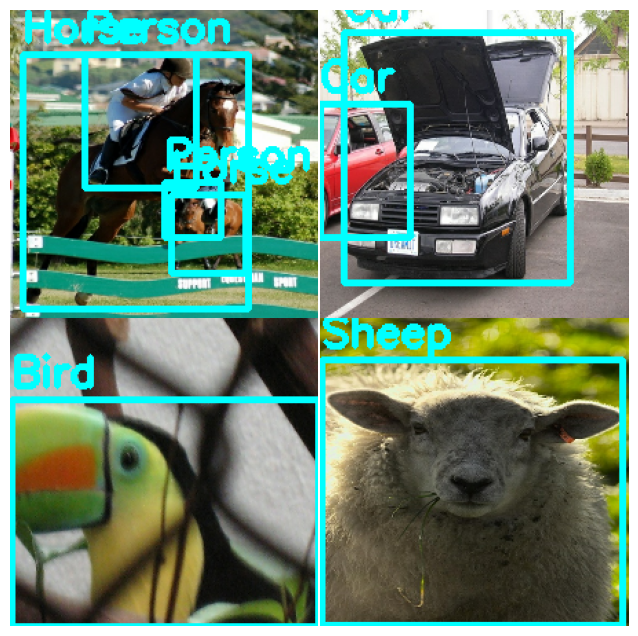

In [ ]:
visualize_dataset(ds_train,bounding_box_format="xywh")

In [ ]:
ds_train

<BatchDataset element_spec={'images': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([None, None, 4]), tf.float32, 1, tf.int64)}}>

In [ ]:

IMG_SIZE = 224
DENSE1_SIZE = 4096
batch_size = 32
class YOLOModel(tf.keras.Model):

  def __init__(self,optimizer, boxes, gridsize,num_classes):
      super().__init__()
      self.optimizer = optimizer
      self.gridsize = gridsize
      self.num_classes = num_classes
      self.boxes = boxes
      # declare base model
      self.base_model = tf.keras.applications.EfficientNetB0(include_top = False,weights="imagenet",pooling="max")
      self.base_model.trainable = False
      self.dense1 = tf.keras.layers.Dense(DENSE1_SIZE)
      self.leaky1 = tf.keras.layers.LeakyReLU(alpha=0.1)
      output_size = (gridsize*gridsize) *(boxes*5+ num_classes)
      self.dense2 = tf.keras.layers.Dense(output_size)
      self.softmax = tf.keras.layers.Softmax()

  def call(self,inputs):
      x = self.base_model(inputs)
      #x = tf.squeeze(x)
      x = self.dense1(x)
      x = self.leaky1(x)
      x = self.dense2(x)
      # reshape to given tensor by yolo object detection
      x = tf.reshape(x,[-1,self.gridsize,self.gridsize,self.boxes*5+self.num_classes])
      class_begin_idx = classes_begin(self.boxes)
      bboxes, class_probs = tf.split(x,num_or_size_splits=[class_begin_idx,self.num_classes],axis=-1)
      # softmax
      class_probs = self.softmax(class_probs)
      x = tf.concat((bboxes, class_probs),-1)
      return x

In [ ]:
def bbox_confidence_index(bbox_int):
  return 4+5*bbox_int

def classes_begin(bbox_amount):
  return 5*bbox_amount

def get_bbox_from_index(bbox_index,class_box_1d_tensor):
  return class_box_1d_tensor[bbox_index*5:bbox_index*5+5]

def get_highest_prob_bbox(grid_output,bbox_amount):
  max_index = 0
  for bbox in range(bbox_amount):
    index = bbox_confidence_index(bbox)
    if grid_output[index] > grid_output[max_index]:
      max_index = index
  return max_index

OutImage_width  = 416
OutImage_height = 416
def transform_boxes(boxes, image):
        image_height, image_width, image_channels = image.shape
        height_diff = OutImage_height/image_height
        width_diff = OutImage_width/image_width
        for line in boxes:
          for box in line:
            box[0] = box[0]*width_diff  # x 
            box[1] = box[1]*height_diff # y
            box[2] = box[2]*width_diff  # w
            box[3] = box[3]*height_diff # h


def yolo_output_to_final_prediction(output, bbox_amount, num_classes):
  # delete low probability
  shape = output.shape
  #iterate over tensor
  indices = []
  for i in range(shape[0]):
    for j in range(shape[1]):
      index = get_highest_prob_bbox(output[i][j])
      indices.append(index)
  # get same object bboxes for non maximum suppresion
  # make some sanity checks
  bbox_list = []
  for classes in range(num_classes):
    bbox_list.append(list())
  counter = 0
  # for each index get all the class probabilites via slicing
  # then get the max index   via tf.math.argmax
  for i in range(shape[0]):
    for j in range(shape[1]):
      single_output = output[i][j]
      classes = single_output[bbox_amount*5:]
      class_index = tf.math.argmax(classes)
      bbox = get_bbox_from_index(indices[counter],single_output)
      # save it for each bbox prediction and then put all boxes with the same class into non maximum supression...
      bbox_list[class_index].append(bbox)
      counter += 1
  final_boxes = []
  for idx,class_boxes in enumerate(bbox_list):
    bbox_tensor = tf.transpose(tf.convert_to_tensor(class_boxes), [1, 0, 2])
    selected_bbox_indices = tf.image.non_max_suppresion(bbox_tensor[:,:3],bbox_tensor[:,4:5])
    selected_boxes = tf.gather(bbox_tensor,selected_bbox_indices)
    final_boxes.append(selected_boxes)
  return final_boxes

  

 

In [ ]:
def get_iou_for_boxes(true_boxes, pred_boxes):
  # Calculate the IoU
  x1 = tf.maximum(true_boxes[..., 0], pred_boxes[..., 0])
  y1 = tf.maximum(true_boxes[..., 1], pred_boxes[..., 1])
  x2 = tf.minimum(true_boxes[..., 2], pred_boxes[..., 2])
  y2 = tf.minimum(true_boxes[..., 3], pred_boxes[..., 3])

  intersection_area = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

  box1_area = (true_boxes[..., 2] - true_boxes[..., 0]) * (true_boxes[..., 3] - true_boxes[..., 1])
  box2_area = (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])

  union_area = box1_area + box2_area - intersection_area

  iou = intersection_area / union_area

  return iou

GRID_SIZE = 7
batch_size = 32
def calc_iou(y_true, pred_boxes,num_boxes):
  #active_grids = tf.math.count_nonzero(y_true[...,classes_begin(num_boxes):],axis=-1)
  #active_grids[active_grids != 0] = 1
  true_boxes = y_true[...,:classes_begin(num_boxes)]

  true_boxes = tf.reshape(true_boxes,[-1,GRID_SIZE,GRID_SIZE,num_boxes,5])
  #true_boxes = tf.reshape(true_boxes,[-1,true_boxes[1],true_boxes[2],num_boxes,5])
  return get_iou_for_boxes(true_boxes,pred_boxes)

In [ ]:
batch_size = 32

class YOLOLoss(tf.keras.losses.Loss):
  def __init__(self, num_classes, num_boxes, grid_size,lambda_coord = 5, lambda_noobj = 0.5):
    super().__init__()
    self.num_classes = num_classes
    self.num_boxes = num_boxes
    self.lambda_coord = lambda_coord
    self.lamda_noobj = lambda_noobj
    self.GRID_SIZE = grid_size
  def call(self, y_true, y_pred):
    class_begin_idx = classes_begin(self.num_boxes)
    pred_boxes = y_pred[...,:class_begin_idx]
    pred_boxes = tf.reshape(pred_boxes,[-1,self.GRID_SIZE,self.GRID_SIZE,self.num_boxes,5])
    # now calculate iou with the y_true
    # y_true supposed to be a tensor of same size as output -> S*S *(B*5+C)
    # cut of classes as first
    true_boxes = tf.cast(y_true[...,:class_begin_idx], dtype=tf.float32)
    iou_tensor = calc_iou(true_boxes,pred_boxes,self.num_boxes)
    # iou tensor should be of shape (None, S,S, B) where None is batch size, S is gridsize and B should be the number of boxes containing an iou
    max_iou_idx = tf.math.argmax(iou_tensor,axis=-1)
    #max_confidence_idx = tf.math.argmax(max_[:,:,:,:,:4],axis=-1)
    # hab da ma pred_bboxes mit pred_boxes ersetzt
    final_pred_boxes = tf.gather(pred_boxes,max_iou_idx,batch_dims=3)
    # now we have the correct boxes for our loss calculcation
    # here we should use the active grid calculation to determine when the loss is 0.
    active_grids =  tf.cast(tf.math.count_nonzero(y_true[...,classes_begin(self.num_boxes):],axis=-1), dtype=tf.float32)
    active_grids = tf.where(active_grids!= 0, tf.ones_like(active_grids), active_grids)
    xy_loss = self.lambda_coord * K.sum(K.sum(tf.math.multiply(active_grids, K.square(final_pred_boxes[...,0]-true_boxes[...,0])+K.square(final_pred_boxes[...,1]-true_boxes[...,1])),axis=-1),axis=-1)
    wh_loss = self.lambda_coord * K.sum(K.sum(tf.math.multiply(active_grids, K.square(K.sqrt(final_pred_boxes[...,2])-K.sqrt(true_boxes[...,2]))+K.square(K.sqrt(final_pred_boxes[...,3])-K.sqrt(true_boxes[...,3]))),axis=-1),axis=-1)
    confidence_loss = K.sum(K.sum(tf.math.multiply(active_grids,K.square(final_pred_boxes[...,4]- true_boxes[...,4])),axis=-1),axis=-1)
    inverted_active_grids = tf.math.logical_not(tf.cast(active_grids,dtype=tf.bool))
    inverted_active_grids = tf.cast(inverted_active_grids,dtype=tf.float32)

    #hat das self.lambda_noobj nicht gefunden (warum auch immer)
    lambda_noobj = 0.5

    noob_confidence_loss = lambda_noobj *K.sum(K.sum(tf.math.multiply(inverted_active_grids,K.square(final_pred_boxes[...,4]- true_boxes[...,4])),axis=-1),axis=-1)
    class_prob_loss = K.sum(K.sum(tf.math.multiply(active_grids,K.sum(K.square(y_pred[...,class_begin_idx:]-y_true[...,class_begin_idx:]),axis=-1)),axis=-1),axis=-1)
    return xy_loss + wh_loss + confidence_loss + noob_confidence_loss + class_prob_loss
    

In [ ]:
import sys
GRID_SIZE = 7
B = 2
C = 20
def preprocess_data(inputs):
    image = inputs["image"]
    image = tf.image.resize(tf.cast(image, tf.float32),[INPUT_SIZE,INPUT_SIZE])
    #image = tf.expand_dims(image,axis=0)
    labels = inputs['objects']['label']
    bboxes = inputs['objects']['bbox']
    bboxes = [INPUT_SIZE,INPUT_SIZE,INPUT_SIZE,INPUT_SIZE]*bboxes
    grid_size = (INPUT_SIZE / GRID_SIZE ,INPUT_SIZE / GRID_SIZE)
    # Loop over all objects in the image
    predictions = tf.zeros((GRID_SIZE,GRID_SIZE,(B*5)+C),dtype=tf.float32)
    for j in range(tf.size(labels)):
        # Compute the center coordinates and dimensions relative to the grid cell
        x = (bboxes[j][1] + bboxes[j][3]) / 2
        y = (bboxes[j][0] + bboxes[j][2]) / 2
        w = (bboxes[j][3] - bboxes[j][1]) / INPUT_SIZE
        h = (bboxes[j][2] - bboxes[j][0]) /INPUT_SIZE

        x_cell = x // grid_size[0]
        x_cell = tf.math.minimum(x_cell, GRID_SIZE-1)
        x_cell = tf.math.maximum(x_cell, 0)
        y_cell = y // grid_size[1]
        y_cell = tf.math.minimum(y_cell, GRID_SIZE-1)
        y_cell = tf.math.maximum(y_cell, 0)
        # Create a tensor for the predicted bounding boxes and class probabilities for this object
        
        bboxes_tensor = [x - x_cell*grid_size[0], y - y_cell*grid_size[1], w, h,1.0]
        bboxes_tensor = tf.tile(bboxes_tensor,[B])
        #exit()

        class_tensor = tf.zeros([C],dtype=tf.float32)
        class_tensor = tf.tensor_scatter_nd_update(class_tensor, [[labels[j]]], [1])
        #class_tensor = tf.tensor_scatter_nd_update(class_tensor, [labels[j]], 1)
        #obj_pred = np.zeros(B*5+C, dtype=np.float32)
        #class_tensor =
        # Assign the object's center coordinates and dimensions to the appropriate indices
        #xPos = tf.cast(x - x_cell*grid_size[0], dtype=tf.int32)
        #yPos = int(y - y_cell*grid_size[1])
        #with tf.Session() as sess:
          #xPos = int(bboxes[j][1].eval())

          #obj_pred[0:4] = [xPos, 2, 3, 4]
        # Assign the object's confidence score to the appropriate index
        #obj_pred[B*4:B*4+B*1] = [1]

        # Assign the object's class probability to the appropriate index
        #obj_pred[4:5] = 1
        obj_pred = tf.concat([bboxes_tensor,class_tensor],axis= 0)
        # Assign the object's tensor to the appropriate grid cell
        #predictions[y_cell, x_cell, :] = obj_pred
        updates_length = B*5+C
        obj_pred = tf.concat([bboxes_tensor,class_tensor],axis= 0)
        indices_0 = tf.ones((updates_length,), dtype=tf.int32)*int(y_cell)
        indices_1 = tf.ones((updates_length,), dtype=tf.int32)*int(x_cell)
        indices_2 = tf.range(updates_length, dtype=tf.int32)
        indices = tf.stack([indices_0, indices_1, indices_2], axis=-1)
        
        # Assign the object's tensor to the appropriate grid cell
        #predictions[y_cell, x_cell, :] = obj_pred
        predictions = tf.tensor_scatter_nd_update(predictions, indices, obj_pred)
        
# Das Problem liegt scheinbar an dieser Ausgabe
    
    tf.print(image,output_stream=sys.stdout)
    # this was just for testing purposes
    #predictions = tf.zeros((GRID_SIZE,GRID_SIZE,(B*5)+C),dtype=tf.float32)
    return image, predictions

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model = YOLOModel(optimizer, B, GRID_SIZE, C)



In [ ]:
import tensorflow_ranking as tfr
ds, ds_info = tfds.load("voc",split=["train","test"],with_info=True)
training_data = ds[0]
training_data = training_data.map(preprocess_data)
training_data = training_data.batch(32)
validation_data = ds[1]
validation_data = validation_data.map(preprocess_data)
validation_data = validation_data.batch(32)
model.compile(optimizer="adam",loss=YOLOLoss(C,B,GRID_SIZE),metrics=["acc"])

In [ ]:
history = model.fit(training_data,epochs=10,validation_data= validation_data)

Streaming output truncated to the last 5000 lines.
  [127.671432 147.850098 135.350067]]]
[[[110.722336 115.722336 108.722336]
  [62.2995071 65.2995071 58.2995071]
  [63.8031158 64.642395 59.7227554]
  ...
  [154.007141 152.007141 153.007141]
  [156 154 155]
  [154.765945 152.765945 153.765945]]

 [[115.649353 119.189529 112.189529]
  [64.3295364 65.8697205 59.5996284]
  [63.3873978 62.7082062 57.8472176]
  ...
  [157.716125 155.716125 156.716125]
  [155.38089 153.38089 154.38089]
  [155.51236 153.51236 154.51236]]

 [[119.745071 122.312042 115.528557]
  [68.3766174 69.3766174 63.3766136]
  [65.4098 64.1687241 59.3294411]
  ...
  [157.219254 155.652298 156.834015]
  [156.551971 154.985 155.768478]
  [156.532928 154.965958 155.749451]]

 ...

 [[46.5994072 21.7511902 6.80024624]
  [56.5906334 24.8623619 10.0141459]
  [63.6494751 29.7661114 14.6018105]
  ...
  [77.3643494 25.4447021 4.60540676]
  [79.9457626 28.4001217 6.49768066]
  [78.1333694 27.9168797 5.34986305]]

 [[72.0915756 38.9

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'history.json' 
from google.colab import files

with open(hist_json_file, 'w') as f:
  hist_df.to_json(f)

files.download(hist_json_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>